### Toolbox for Model Monitoring
---

Use this as the factory for building a model validation library. Tools to include:

- Metrics
    - General Modeling
        - [ ] AUC
        - [ ] AP
        - [ ] KS
    - FICO reported scores
        - [ ] AFPR: Account False-Positive Ratio
        - [ ] ADR: Account Detection Rate
        - [ ] RTVDR: Real-Time Value Detection Rate


- Plots
    - General Modeling
        - [ ] TPR vs. FPR (for AUC)
        - [ ] Precision Recall Curve (for AP)
        - [ ] KS
    - FICO reported scores
        - [ ] ADR vs. AFPR
        - [ ] RTVDR vs. AFPR
        - [ ] ADR vs. Threshold Score
        - [ ] RTVDR vs. Threhold Score
        - [ ] Transaction Above Threhold Score vs. Threshold Score
        - [ ] AFPR vs. Threshold Score
        - [ ] Case Multiplier (K) vs. Threshold Score
        
        
- Performance Table
    - List AFPR, ADR, RTVDR, K, Score distribution segemented by threshold score!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot.metrics as spm

#### Data and Model
---
First get a trained model and a sample OOT data

In [7]:
import pandas as pd
import numpy as np
import pickle
# from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped

In [8]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

def train_lgb_baseline_grouped(df, features, params, target_col_name='target', group_col_name='business_account_number', num_folds=5, seed=12345, 
                               n_boost_rounds=100000, early_stopping_rounds=1000, verbose_eval=500, weight_col_name=None):
    """
    Train LightGBM models over 5 folds, return OOF predictions, trained models, and average AUC over 5 folds.
    """
    kf = GroupKFold(num_folds)
    split = kf.split(X=df, y=df[target_col_name], groups=df[group_col_name])

    train_pred = np.zeros(len(df))
    feature_importance_df = pd.DataFrame()

    models = []

    for i, (train_idx, test_idx) in enumerate(split):
        train = df.iloc[train_idx].copy()
        test = df.iloc[test_idx].copy()

        if weight_col_name:
            wtr = train[weight_col_name]
            wts = test[weight_col_name]
        else:
            wtr = None
            wts = None
        
        lgb_train = lgb.Dataset(train[features],
                                label=train[target_col_name],
                                free_raw_data=False,
                                weight=wtr)
        lgb_test = lgb.Dataset(test[features],
                               label=test[target_col_name],
                               free_raw_data=False,
                               weight=wts)

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_test],
                          valid_names=['train', 'test'],
                          num_boost_round=n_boost_rounds,
                          early_stopping_rounds= early_stopping_rounds,
                          verbose_eval=verbose_eval)
        models.append(model)

        train_pred[test_idx] = model.predict(test[features], num_iteration=model.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = model.feature_importance(importance_type='gain', 
                                                                    iteration=model.best_iteration)
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    auc = roc_auc_score(y_true=df[target_col_name].values, y_score=train_pred)

    return train_pred, feature_importance_df, models, auc

In [9]:
from collections import defaultdict

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'giact_time_since_last_link', 'phone_risk_score',
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
    df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df

In [31]:
with open('../../models/customer_risk_target_thomas.pkl', 'rb') as f:
    model = pickle.load(f)
    
modeling_df = pd.read_feather('../../artifacts/modeling_df_final_2020-05-14.feather')
modeling_df = preprocess(modeling_df)
# 01-06-2020
df_oot = pd.read_csv('../../artifacts/oot_samples_asof_010620_scored_1595615256.csv')

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [15]:
seed = 15556
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "num_iterations": 1400,
    "max_depth" : 4,
    "num_leaves" : 15,
    "learning_rate" : 0.03,
    "feature_fraction" : 0.8,
    "subsample": 0.94,
    "lambda_l1": 16,
    "lambda_l2": 10,
    "min_data_in_leaf": 116,
    "tree_learner": "feature",
    "bagging_seed" : seed,
    "verbosity" : 1,
    "seed": seed,
    "categorical_feature": [40, 41, 42]
}

count_pos = modeling_df['target'].sum()
count_neg = (~modeling_df['target']).sum()
pos_wgt_scaling_factor = count_neg / count_pos

params['scale_pos_weight'] = pos_wgt_scaling_factor
pred, feature_importance_df, models, auc = train_lgb_baseline_grouped(modeling_df, features, params, target_col_name='target', group_col_name='business_account_number', verbose_eval=500, n_boost_rounds=10000, early_stopping_rounds=150)
modeling_df['pred'] = pred

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


Training until validation scores don't improve for 150 rounds
[500]	train's auc: 0.973619	test's auc: 0.955859
Early stopping, best iteration is:
[626]	train's auc: 0.975924	test's auc: 0.956142
Training until validation scores don't improve for 150 rounds
[500]	train's auc: 0.973197	test's auc: 0.9606
[1000]	train's auc: 0.980381	test's auc: 0.961382
Early stopping, best iteration is:
[1072]	train's auc: 0.981196	test's auc: 0.96146
Training until validation scores don't improve for 150 rounds
[500]	train's auc: 0.973821	test's auc: 0.960402
Early stopping, best iteration is:
[849]	train's auc: 0.979052	test's auc: 0.960728
Training until validation scores don't improve for 150 rounds
[500]	train's auc: 0.9733	test's auc: 0.962413
Early stopping, best iteration is:
[701]	train's auc: 0.976691	test's auc: 0.962712
Training until validation scores don't improve for 150 rounds
[500]	train's auc: 0.973512	test's auc: 0.960913
Early stopping, best iteration is:
[505]	train's auc: 0.973614	

In [16]:
display('OOS AUC: ', auc)

'OOS AUC: '

0.9602798300110735

In [32]:
credit_df = pd.read_feather('../../data/processed/processed_1597860707/experian_credit_pull_1597860707.feather')
dmd = pd.read_feather('../../data/processed/processed_1597860707/user_metadata_dw_1597860707.feather')

In [33]:
credit_df = pd.merge(credit_df[['user_id', 'credit_pull_date', 'fico_score']], dmd[['user_id', 'borrower_id']], how='inner', on='user_id')
credit_df = credit_df.sort_values(by=['credit_pull_date'])
modeling_df = modeling_df.sort_values(by=['sample_date'])
modeling_df = pd.merge_asof(modeling_df, credit_df, left_on='sample_date', right_on='credit_pull_date', by='borrower_id')

In [34]:
import gc
del credit_df 
del dmd
gc.collect()

124

In [36]:
# adjust fico
modeling_df['fico_adjusted'] = modeling_df['fico_score'] * np.where(modeling_df['fico_score'] > 850, 0, 1)
modeling_df['fico_adjusted_2'] = modeling_df['fico_adjusted'].replace(0, np.nan)

False    907663
True     178520
Name: fico_score, dtype: int64

### Metrics
---

In [91]:
def get_binary_metrics(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score
    from scikitplot.helpers import binary_ks_curve
    
    auc = round(roc_auc_score(y_true=y_true,
                              y_score=y_pred)*100, 2)
    ap = round(average_precision_score(y_true=y_true,
                                       y_score=y_pred)*100, 2)
    _, _, _, ks, _, _ = binary_ks_curve(y_true=y_true, y_probas=y_pred)
    ks = round(ks*100, 2) 
    
    metrics = {'auc': auc,
               'ap': ap,
               'ks': ks}

    return metrics

In [92]:
df_ = df_oot_w_transactions
print('fico: ', get_binary_metrics(df_[~df_['fico_score'].isna()].target, df_[~df_['fico_score'].isna()].fico_score))
print('fraud score: ', get_binary_metrics(df_[~df_['fraud_score_2'].isna()].target, df_[~df_['fraud_score_2'].isna()].fraud_score_2))
print('model: ', get_binary_metrics(df_.target, df_.pred_target))

fico:  {'auc': 28.5, 'ap': 4.7, 'ks': 18.63}
fraud score:  {'auc': 72.0, 'ap': 4.83, 'ks': 33.08}
model:  {'auc': 96.21, 'ap': 63.07, 'ks': 82.11}


In [93]:
df_oot1 = pd.read_csv('../../artifacts/oot_samples_asof_010620_scored_1595615256.csv')
df_oot2 = pd.read_csv('../../artifacts/oot_samples_asof_021720_scored_1595615271.csv')
df_oot3 = pd.read_csv('../../artifacts/oot_samples_asof_031520_scored_1595615287.csv')
df_oot4 = pd.read_csv('../../artifacts/oot_samples_asof_041520_scored_1595615305.csv')
dfs = [df_oot1, df_oot2, df_oot3, df_oot4]

In [96]:
for i, df_ in enumerate(dfs):
    df_ = df_[(df_['nr_transactions_next_90d'] > 0) & (df_['nr_past_transactions'] > 0)]
    print(f'month {i+1}: {get_binary_metrics(df_.target, df_.pred_target)}')

month 1: {'auc': 96.21, 'ap': 63.07, 'ks': 82.11}
month 2: {'auc': 95.75, 'ap': 58.44, 'ks': 80.75}
month 3: {'auc': 95.85, 'ap': 54.4, 'ks': 80.48}
month 4: {'auc': 95.76, 'ap': 41.78, 'ks': 80.24}


### Plots
---

In [105]:
import scikitplot as skplt
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [110]:
# convert 1d probability to 2d: [n_data, n_class]
pred_probas = np.stack([1-df_.pred_target, df_.pred_target]).T

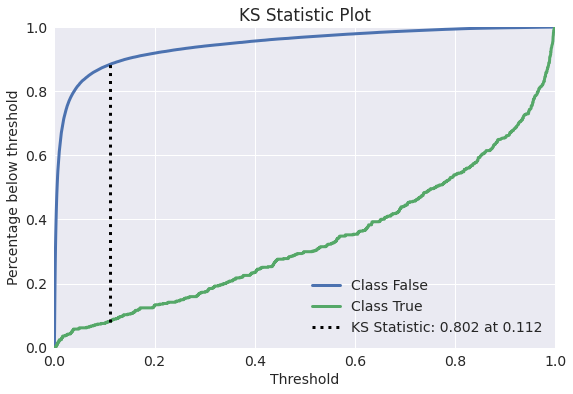

In [111]:
plot = skplt.metrics.plot_ks_statistic(y_true=df_.target,
                                       y_probas=pred_probas)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

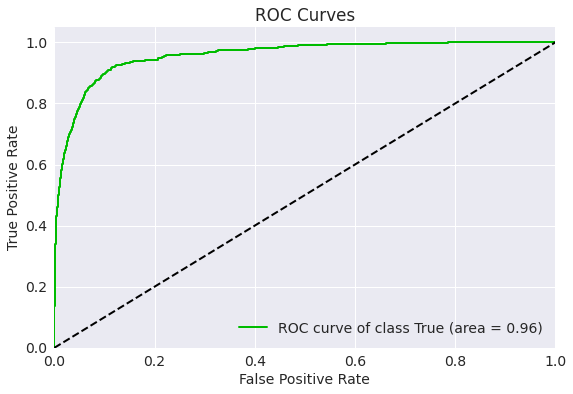

In [116]:
plot = skplt.metrics.plot_roc(y_true=df_.target, 
                              y_probas=pred_probas,
                              plot_macro=False,
                              plot_micro=False, 
                              classes_to_plot=[1])

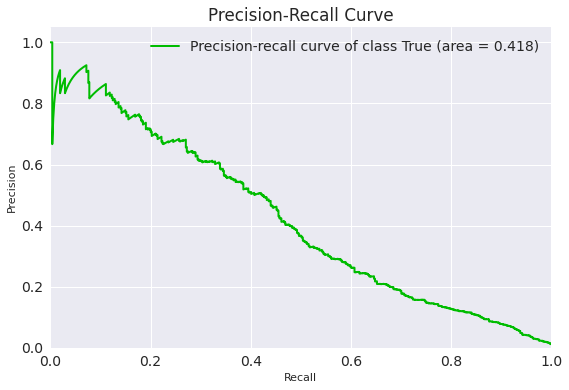

In [117]:
plot = skplt.metrics.plot_precision_recall(y_true=df_.target, 
                                           y_probas=pred_probas,
                                           plot_micro=False, 
                                           classes_to_plot=[1])

In [ ]:
df__ = pd.read_feather('../data/combined_all_features/combined_1597785347.feather')

In [ ]:
1